# Modeling flight delays based on weather

Using a flight dataset from the department of transportation for commercial flights in 2015 and a dataset of the weather for select American cities I plan on modeling the relationship between weather descriptions and flight delays. 

In [140]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

# Cleaning data and merging the two dataframes.

**Flights dataset**

This flights data set contains flight data for 5.8 million commercial flights in 2015. Delays and cancelations are tracked as well as movement times through destination and departure airports.

In [65]:
flights_df = pd.read_csv('/content/flights.csv')

flights_df.info()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [66]:
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
for column in flights_df.columns:
  print(column)
  print("unique value count: {}".format(flights_df[column].nunique()))
  print("unique values: {}".format(flights_df[column].unique()))
  print()

YEAR
unique value count: 1
unique values: [2015]

MONTH
unique value count: 12
unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12]

DAY
unique value count: 31
unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

DAY_OF_WEEK
unique value count: 7
unique values: [4 5 6 7 1 2 3]

AIRLINE
unique value count: 14
unique values: ['AS' 'AA' 'US' 'DL' 'NK' 'UA' 'HA' 'B6' 'OO' 'EV' 'MQ' 'F9' 'WN' 'VX']

FLIGHT_NUMBER
unique value count: 6952
unique values: [  98 2336  840 ... 6777 6895 6887]

TAIL_NUMBER
unique value count: 4897
unique values: ['N407AS' 'N3KUAA' 'N171US' ... 'N7LEAA' 'N850DN' 'N8676A']

ORIGIN_AIRPORT
unique value count: 930
unique values: ['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'MAF' 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'SGF' 'PHL' 'SBN'
 'RDD' 'EUG' 'IAD' 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS'

**Weather dataset**

This weather dataset tracks weather for 36 cities by hour between 2012 and 2017. A limitation of this dataset is that it is unclear if the times are linked to the time zones of the cities or a standard time. 

In [68]:
weather_desc_df = pd.read_csv("/content/weather_description.csv")

weather_desc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   datetime           45253 non-null  object
 1   Vancouver          44460 non-null  object
 2   Portland           45252 non-null  object
 3   San Francisco      44460 non-null  object
 4   Seattle            45252 non-null  object
 5   Los Angeles        45252 non-null  object
 6   San Diego          45252 non-null  object
 7   Las Vegas          45252 non-null  object
 8   Phoenix            45252 non-null  object
 9   Albuquerque        45252 non-null  object
 10  Denver             45252 non-null  object
 11  San Antonio        45252 non-null  object
 12  Dallas             45252 non-null  object
 13  Houston            45252 non-null  object
 14  Kansas City        45252 non-null  object
 15  Minneapolis        45252 non-null  object
 16  Saint Louis        45252 non-null  objec

In [69]:
weather_desc_df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,...,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


The weather dataset has it's location listed by city while the flights dataset has it's location listed by airport. The values need to be converted to be merged.

In [70]:
weather_desc_df["YVR"] = weather_desc_df["Vancouver"]
weather_desc_df["PDX"] = weather_desc_df["Portland"]
weather_desc_df["SFO"] = weather_desc_df["San Francisco"]
weather_desc_df["SEA"] = weather_desc_df["Seattle"]
weather_desc_df["LAX"] = weather_desc_df["Los Angeles"]
weather_desc_df["LAC"] = weather_desc_df["San Diego"]
weather_desc_df["LAS"] = weather_desc_df["Las Vegas"]
weather_desc_df["PHX"] = weather_desc_df["Phoenix"]
weather_desc_df["ABQ"] = weather_desc_df["Albuquerque"]
weather_desc_df["DEN"] = weather_desc_df["Denver"]
weather_desc_df["SAT"] = weather_desc_df["San Antonio"]
weather_desc_df["DFW"] = weather_desc_df["Dallas"]
weather_desc_df["IAH"] = weather_desc_df["Houston"]
weather_desc_df["MCI"] = weather_desc_df["Kansas City"]
weather_desc_df["MSP"] = weather_desc_df["Minneapolis"]
weather_desc_df["BLV"] = weather_desc_df["Saint Louis"]
weather_desc_df["ORD"] = weather_desc_df["Chicago"]
weather_desc_df["BNA"] = weather_desc_df["Nashville"]
weather_desc_df["IND"] = weather_desc_df["Indianapolis"]
weather_desc_df["ATL"] = weather_desc_df["Atlanta"]
weather_desc_df["DTW"] = weather_desc_df["Detroit"]
weather_desc_df["JAX"] = weather_desc_df["Jacksonville"]
weather_desc_df["CLT"] = weather_desc_df["Charlotte"]
weather_desc_df["MIA"] = weather_desc_df["Miami"]
weather_desc_df["PIT"] = weather_desc_df["Pittsburgh"]
weather_desc_df["YYZ"] = weather_desc_df["Toronto"]
weather_desc_df["PHL"] = weather_desc_df["Philadelphia"]
weather_desc_df["JFK"] = weather_desc_df["New York"]
weather_desc_df["YUL"] = weather_desc_df["Montreal"]
weather_desc_df["BOS"] = weather_desc_df["Boston"]

airports_list = ["YVR","PDX","SFO","SEA","LAX","LAC","LAS","PHX","ABQ","DEN","SAT","DFW","IAH","MCI","MSP","BLV","ORD","BNA","IND","ATL","DTW","JAX","CLT","MIA","PIT","YYZ","PHL","JFK","YUL","BOS"]

In [71]:
weather_column_list = airports_list
weather_column_list.extend(["datetime"])

weather_desc_df = weather_desc_df.drop(columns=[column for column in weather_desc_df if column not in weather_column_list])

weather_desc_df["Index"] = weather_desc_df.index

The dataframe needs to be reoriented to be merged with the flights dataset. The time stamp needs to be broken up by month, day, and hour for the same reason.

In [72]:
weather_fixed_df = pd.melt(weather_desc_df, id_vars="datetime", value_vars=airports_list, var_name="airport")

weather_fixed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357590 entries, 0 to 1357589
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   datetime  1357590 non-null  object
 1   airport   1357590 non-null  object
 2   value     1354392 non-null  object
dtypes: object(3)
memory usage: 31.1+ MB


In [73]:
weather_fixed_df["year"] = pd.DatetimeIndex(weather_fixed_df["datetime"]).year
weather_fixed_df["month"] = pd.DatetimeIndex(weather_fixed_df["datetime"]).month
weather_fixed_df["day"] = pd.DatetimeIndex(weather_fixed_df["datetime"]).day
weather_fixed_df["hour"] = pd.DatetimeIndex(weather_fixed_df["datetime"]).hour

In [74]:
weather_fixed_df = weather_fixed_df[weather_fixed_df['year'] == 2015]

weather_fixed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262800 entries, 19716 to 1340812
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   datetime  262800 non-null  object
 1   airport   262800 non-null  object
 2   value     262800 non-null  object
 3   year      262800 non-null  int64 
 4   month     262800 non-null  int64 
 5   day       262800 non-null  int64 
 6   hour      262800 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 16.0+ MB


Reducing flights dataset based on the airports in weather dataset.

In [75]:
flights_df = flights_df[flights_df['ORIGIN_AIRPORT'].isin(airports_list)]
flights_df = flights_df[flights_df['DESTINATION_AIRPORT'].isin(airports_list)]

flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322264 entries, 2 to 5819074
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1322264 non-null  int64  
 1   MONTH                1322264 non-null  int64  
 2   DAY                  1322264 non-null  int64  
 3   DAY_OF_WEEK          1322264 non-null  int64  
 4   AIRLINE              1322264 non-null  object 
 5   FLIGHT_NUMBER        1322264 non-null  int64  
 6   TAIL_NUMBER          1317657 non-null  object 
 7   ORIGIN_AIRPORT       1322264 non-null  object 
 8   DESTINATION_AIRPORT  1322264 non-null  object 
 9   SCHEDULED_DEPARTURE  1322264 non-null  int64  
 10  DEPARTURE_TIME       1307412 non-null  float64
 11  DEPARTURE_DELAY      1307412 non-null  float64
 12  TAXI_OUT             1306830 non-null  float64
 13  WHEELS_OFF           1306830 non-null  float64
 14  SCHEDULED_TIME       1322263 non-null  float64
 15

In [76]:
print("unique value count: {}".format(flights_df["CANCELLATION_REASON"].nunique()))
print("unique values: {}".format(flights_df["CANCELLATION_REASON"].unique()))

unique value count: 3
unique values: [nan 'B' 'A' 'C']


In [77]:
flights_df = flights_df.drop(columns = ["CANCELLATION_REASON", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"])
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322264 entries, 2 to 5819074
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1322264 non-null  int64  
 1   MONTH                1322264 non-null  int64  
 2   DAY                  1322264 non-null  int64  
 3   DAY_OF_WEEK          1322264 non-null  int64  
 4   AIRLINE              1322264 non-null  object 
 5   FLIGHT_NUMBER        1322264 non-null  int64  
 6   TAIL_NUMBER          1317657 non-null  object 
 7   ORIGIN_AIRPORT       1322264 non-null  object 
 8   DESTINATION_AIRPORT  1322264 non-null  object 
 9   SCHEDULED_DEPARTURE  1322264 non-null  int64  
 10  DEPARTURE_TIME       1307412 non-null  float64
 11  DEPARTURE_DELAY      1307412 non-null  float64
 12  TAXI_OUT             1306830 non-null  float64
 13  WHEELS_OFF           1306830 non-null  float64
 14  SCHEDULED_TIME       1322263 non-null  float64
 15

In [78]:
flights_df = flights_df.dropna()
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303781 entries, 2 to 5819074
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1303781 non-null  int64  
 1   MONTH                1303781 non-null  int64  
 2   DAY                  1303781 non-null  int64  
 3   DAY_OF_WEEK          1303781 non-null  int64  
 4   AIRLINE              1303781 non-null  object 
 5   FLIGHT_NUMBER        1303781 non-null  int64  
 6   TAIL_NUMBER          1303781 non-null  object 
 7   ORIGIN_AIRPORT       1303781 non-null  object 
 8   DESTINATION_AIRPORT  1303781 non-null  object 
 9   SCHEDULED_DEPARTURE  1303781 non-null  int64  
 10  DEPARTURE_TIME       1303781 non-null  float64
 11  DEPARTURE_DELAY      1303781 non-null  float64
 12  TAXI_OUT             1303781 non-null  float64
 13  WHEELS_OFF           1303781 non-null  float64
 14  SCHEDULED_TIME       1303781 non-null  float64
 15

In [79]:
flights_df['Depart time rounded'] = (flights_df['SCHEDULED_DEPARTURE'] / 100).astype(int)
flights_df['Arrive time rounded'] = (flights_df['SCHEDULED_ARRIVAL'] / 100).astype(int)

The weather dataset needs to be merged twice. Once for departing flights and once for arriving flights.

In [80]:
wf_df = pd.merge(flights_df, weather_fixed_df[["month", "day", "hour", "airport", "value"]], 
                 left_on=["MONTH", "DAY", "Depart time rounded", "ORIGIN_AIRPORT"], 
                 right_on=["month", "day", "hour", "airport"],
                 how='left')
wf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303781 entries, 0 to 1303780
Data columns (total 32 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1303781 non-null  int64  
 1   MONTH                1303781 non-null  int64  
 2   DAY                  1303781 non-null  int64  
 3   DAY_OF_WEEK          1303781 non-null  int64  
 4   AIRLINE              1303781 non-null  object 
 5   FLIGHT_NUMBER        1303781 non-null  int64  
 6   TAIL_NUMBER          1303781 non-null  object 
 7   ORIGIN_AIRPORT       1303781 non-null  object 
 8   DESTINATION_AIRPORT  1303781 non-null  object 
 9   SCHEDULED_DEPARTURE  1303781 non-null  int64  
 10  DEPARTURE_TIME       1303781 non-null  float64
 11  DEPARTURE_DELAY      1303781 non-null  float64
 12  TAXI_OUT             1303781 non-null  float64
 13  WHEELS_OFF           1303781 non-null  float64
 14  SCHEDULED_TIME       1303781 non-null  float64
 15

In [81]:
wf_df = wf_df.rename(columns={"value":"ORIGIN_WEATHER"})

wf_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,Depart time rounded,Arrive time rounded,month,day,hour,airport,ORIGIN_WEATHER
0,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,0,8,1,1,0,SFO,sky is clear
1,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,0,8,1,1,0,LAX,moderate rain
2,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,8.0,0,0,0,6,1,1,0,SFO,sky is clear
3,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,-17.0,0,0,0,5,1,1,0,LAS,overcast clouds
4,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,-10.0,0,0,0,8,1,1,0,LAX,moderate rain


In [82]:
wf_df = pd.merge(wf_df, weather_fixed_df[["month", "day", "hour", "airport", "value"]], 
                 left_on=["MONTH", "DAY", "Arrive time rounded", "DESTINATION_AIRPORT"], 
                 right_on=["month", "day", "hour", "airport"],
                 how='left')

wf_df = wf_df.rename(columns={"value":"DESTINATION_WEATHER"})

wf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303781 entries, 0 to 1303780
Data columns (total 37 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1303781 non-null  int64  
 1   MONTH                1303781 non-null  int64  
 2   DAY                  1303781 non-null  int64  
 3   DAY_OF_WEEK          1303781 non-null  int64  
 4   AIRLINE              1303781 non-null  object 
 5   FLIGHT_NUMBER        1303781 non-null  int64  
 6   TAIL_NUMBER          1303781 non-null  object 
 7   ORIGIN_AIRPORT       1303781 non-null  object 
 8   DESTINATION_AIRPORT  1303781 non-null  object 
 9   SCHEDULED_DEPARTURE  1303781 non-null  int64  
 10  DEPARTURE_TIME       1303781 non-null  float64
 11  DEPARTURE_DELAY      1303781 non-null  float64
 12  TAXI_OUT             1303781 non-null  float64
 13  WHEELS_OFF           1303781 non-null  float64
 14  SCHEDULED_TIME       1303781 non-null  float64
 15

In [83]:
#dropping unneeded columns

wf_df = wf_df.drop(columns=["YEAR", "TAIL_NUMBER", "Depart time rounded", "Arrive time rounded", "month_x", "day_x",
                            "hour_x", "airport_x", "month_y", "day_y", "hour_y", "airport_y"])

wf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303781 entries, 0 to 1303780
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   MONTH                1303781 non-null  int64  
 1   DAY                  1303781 non-null  int64  
 2   DAY_OF_WEEK          1303781 non-null  int64  
 3   AIRLINE              1303781 non-null  object 
 4   FLIGHT_NUMBER        1303781 non-null  int64  
 5   ORIGIN_AIRPORT       1303781 non-null  object 
 6   DESTINATION_AIRPORT  1303781 non-null  object 
 7   SCHEDULED_DEPARTURE  1303781 non-null  int64  
 8   DEPARTURE_TIME       1303781 non-null  float64
 9   DEPARTURE_DELAY      1303781 non-null  float64
 10  TAXI_OUT             1303781 non-null  float64
 11  WHEELS_OFF           1303781 non-null  float64
 12  SCHEDULED_TIME       1303781 non-null  float64
 13  ELAPSED_TIME         1303781 non-null  float64
 14  AIR_TIME             1303781 non-null  float64
 15

In [84]:
print("Distribution of canceled flights: {}".format(wf_df["CANCELLED"].value_counts()))
print("unique value count: {}".format(wf_df["CANCELLED"].nunique()))

Distribution of canceled flights: 0    1303781
Name: CANCELLED, dtype: int64
unique value count: 1


In [85]:
print("DEPARTURE_DELAY")
print("unique value count: {}".format(wf_df["DEPARTURE_DELAY"].nunique()))
print()
print("ARRIVAL_DELAY")
print("unique value count: {}".format(wf_df["ARRIVAL_DELAY"].nunique()))

DEPARTURE_DELAY
unique value count: 896

ARRIVAL_DELAY
unique value count: 935


In [86]:
#columns that will need dummies

print("AIRLINE")
print("unique value count: {}".format(wf_df["AIRLINE"].nunique()))
print("unique values: {}".format(wf_df["AIRLINE"].unique()))
print()
print("ORIGIN_AIRPORT")
print("unique value count: {}".format(wf_df["ORIGIN_AIRPORT"].nunique()))
print("unique values: {}".format(wf_df["ORIGIN_AIRPORT"].unique()))
print()
print("DESTINATION_AIRPORT")
print("unique value count: {}".format(wf_df["DESTINATION_AIRPORT"].nunique()))
print("unique values: {}".format(wf_df["DESTINATION_AIRPORT"].unique()))
print()
print("ORIGIN_WEATHER")
print("unique value count: {}".format(wf_df["ORIGIN_WEATHER"].nunique()))
print("unique values: {}".format(wf_df["ORIGIN_WEATHER"].unique()))
print()
print("DESTINATION_WEATHER")
print("unique value count: {}".format(wf_df["DESTINATION_WEATHER"].nunique()))
print("unique values: {}".format(wf_df["DESTINATION_WEATHER"].unique()))

AIRLINE
unique value count: 13
unique values: ['US' 'AA' 'DL' 'NK' 'UA' 'EV' 'B6' 'F9' 'OO' 'WN' 'AS' 'VX' 'MQ']

ORIGIN_AIRPORT
unique value count: 25
unique values: ['SFO' 'LAX' 'LAS' 'DEN' 'SEA' 'PDX' 'PHX' 'ORD' 'DFW' 'BOS' 'IAH' 'BNA'
 'PHL' 'MCI' 'SAT' 'JFK' 'MSP' 'IND' 'PIT' 'MIA' 'JAX' 'CLT' 'DTW' 'ATL'
 'ABQ']

DESTINATION_AIRPORT
unique value count: 25
unique values: ['CLT' 'MIA' 'MSP' 'DFW' 'ATL' 'IAH' 'MCI' 'ORD' 'PHX' 'DTW' 'DEN' 'BOS'
 'JFK' 'LAX' 'SFO' 'PHL' 'SEA' 'LAS' 'PIT' 'PDX' 'BNA' 'JAX' 'IND' 'SAT'
 'ABQ']

ORIGIN_WEATHER
unique value count: 36
unique values: ['sky is clear' 'moderate rain' 'overcast clouds' 'light snow'
 'light rain' 'few clouds' 'scattered clouds' 'broken clouds'
 'heavy intensity rain' 'snow' 'heavy snow' 'mist' 'haze' 'fog'
 'very heavy rain' 'light intensity drizzle' 'proximity thunderstorm'
 'thunderstorm with light rain' 'thunderstorm'
 'light intensity shower rain' 'proximity shower rain' 'drizzle'
 'thunderstorm with rain' 'thunderstorm w

# Graphing and examining data relationships

**Delays per airline**

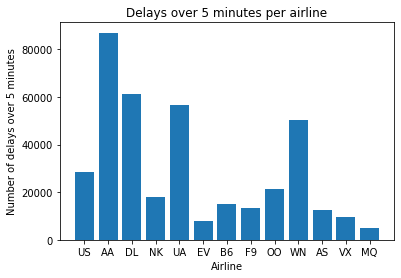

In [87]:
delay_count = wf_df

delay =[]
for row in delay_count['ARRIVAL_DELAY']:
    if row > 5:
        delay.append(1)
    else:
        delay.append(0)  

delay_count["IS_DELAYED"] = delay

ylist = []

for airline in delay_count["AIRLINE"].unique():
  ylist.append(delay_count[delay_count['AIRLINE'] == airline]["IS_DELAYED"].sum())

plt.bar(delay_count["AIRLINE"].unique(), ylist, bottom=0)
plt.title("Delays over 5 minutes per airline")
plt.xlabel("Airline")
plt.ylabel("Number of delays over 5 minutes")
plt.show()

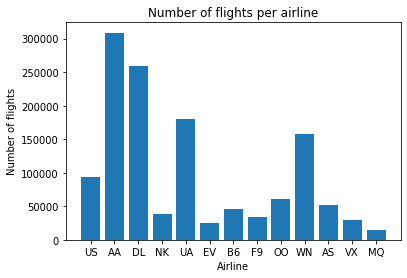

In [88]:
ylist2 = []

for airline in delay_count["AIRLINE"].unique():
  ylist2.append(delay_count[delay_count['AIRLINE'] == airline]["IS_DELAYED"].count())

plt.bar(delay_count["AIRLINE"].unique(), ylist2, bottom=0)
plt.title("Number of flights per airline")
plt.xlabel("Airline")
plt.ylabel("Number of flights")
plt.show()

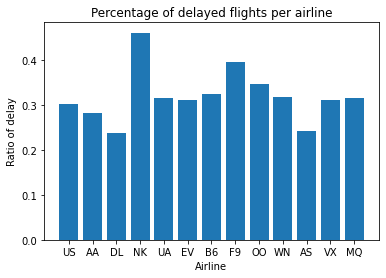

In [89]:
percent_delayed = [x/y for (x, y) in zip(ylist, ylist2)]

plt.bar(delay_count["AIRLINE"].unique(), percent_delayed, bottom=0)
plt.title("Percentage of delayed flights per airline")
plt.xlabel("Airline")
plt.ylabel("Ratio of delay")
plt.show()

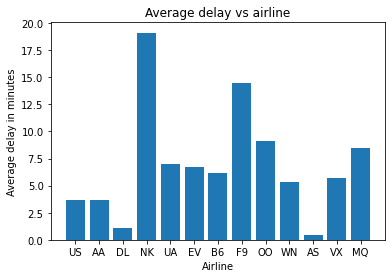

In [90]:
ylist = []

for airline in delay_count["AIRLINE"].unique():
  ylist.append(delay_count[delay_count['AIRLINE'] == airline]["ARRIVAL_DELAY"].mean())

plt.bar(wf_df["AIRLINE"].unique(), ylist, bottom=0)
plt.title("Average delay vs airline")
plt.xlabel("Airline")
plt.ylabel("Average delay in minutes")
plt.show()

**Delays by departure airport**

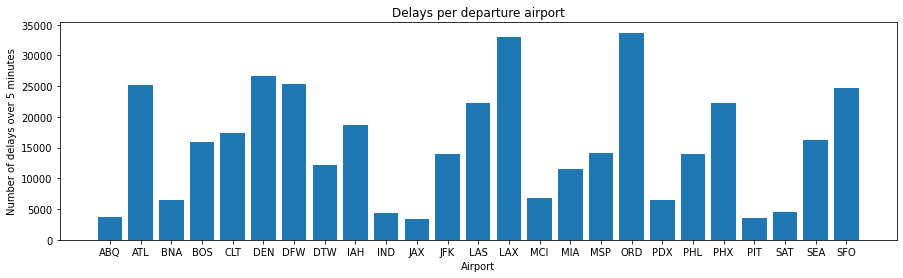

In [91]:
ylist = []

for airport in sorted(delay_count["ORIGIN_AIRPORT"].unique()):
  ylist.append(delay_count[delay_count['ORIGIN_AIRPORT'] == airport]["IS_DELAYED"].sum())

plt.figure(figsize = (15,4))

plt.bar(sorted(delay_count["ORIGIN_AIRPORT"].unique()), ylist, bottom=0)
plt.title("Delays per departure airport")
plt.xlabel("Airport")
plt.ylabel("Number of delays over 5 minutes")
plt.show()

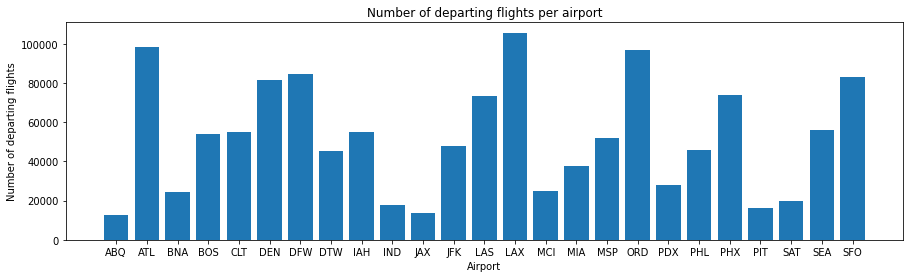

In [92]:
ylist2 = []

for airport in sorted(delay_count["ORIGIN_AIRPORT"].unique()):
  ylist2.append(delay_count[delay_count['ORIGIN_AIRPORT'] == airport]["IS_DELAYED"].count())


plt.figure(figsize=(15,4))
plt.bar(sorted(delay_count["ORIGIN_AIRPORT"].unique()), ylist2, bottom=0)
plt.title("Number of departing flights per airport")
plt.xlabel("Airport")
plt.ylabel("Number of departing flights")
plt.show()

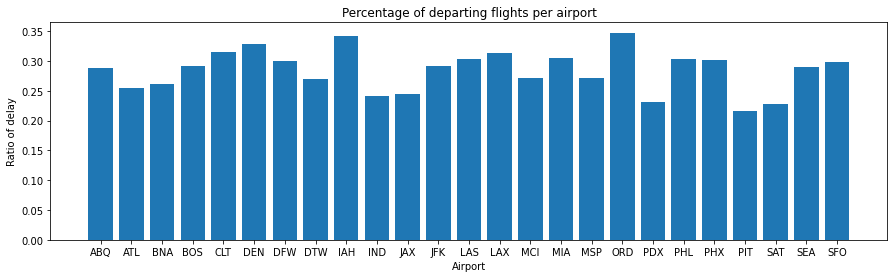

In [93]:
percent_delayed = [x/y for (x, y) in zip(ylist, ylist2)]

plt.figure(figsize=(15,4))
plt.bar(sorted(delay_count["ORIGIN_AIRPORT"].unique()), percent_delayed, bottom=0)
plt.title("Percentage of departing flights per airport")
plt.xlabel("Airport")
plt.ylabel("Ratio of delay")
plt.show()

**Delays by arrival airport**

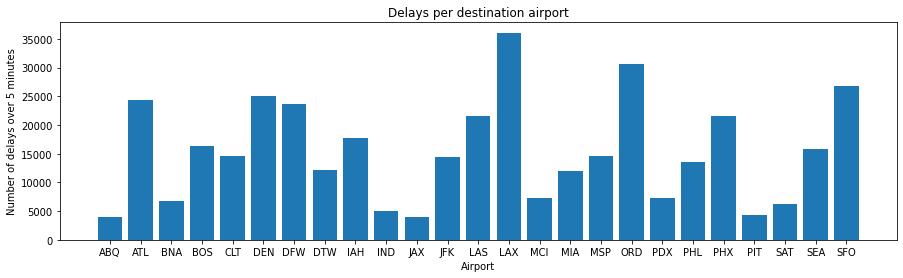

In [94]:
ylist = []

for airport in sorted(delay_count["DESTINATION_AIRPORT"].unique()):
  ylist.append(delay_count[delay_count['DESTINATION_AIRPORT'] == airport]["IS_DELAYED"].sum())

plt.figure(figsize = (15,4))

plt.bar(sorted(delay_count["DESTINATION_AIRPORT"].unique()), ylist, bottom=0)
plt.title("Delays per destination airport")
plt.xlabel("Airport")
plt.ylabel("Number of delays over 5 minutes")
plt.show()

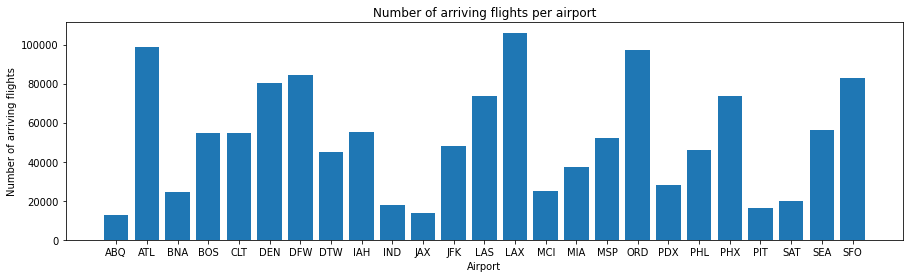

In [95]:
ylist2 = []

for airport in sorted(delay_count["DESTINATION_AIRPORT"].unique()):
  ylist2.append(delay_count[delay_count['DESTINATION_AIRPORT'] == airport]["IS_DELAYED"].count())


plt.figure(figsize=(15,4))
plt.bar(sorted(delay_count["DESTINATION_AIRPORT"].unique()), ylist2, bottom=0)
plt.title("Number of arriving flights per airport")
plt.xlabel("Airport")
plt.ylabel("Number of arriving flights")
plt.show()

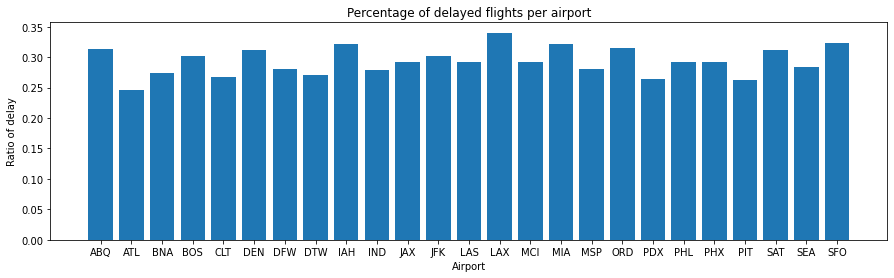

In [96]:
percent_delayed = [x/y for (x, y) in zip(ylist, ylist2)]

plt.figure(figsize=(15,4))
plt.bar(sorted(delay_count["DESTINATION_AIRPORT"].unique()), percent_delayed, bottom=0)
plt.title("Percentage of delayed flights per airport")
plt.xlabel("Airport")
plt.ylabel("Ratio of delay")
plt.show()

**Delays by origin weather**

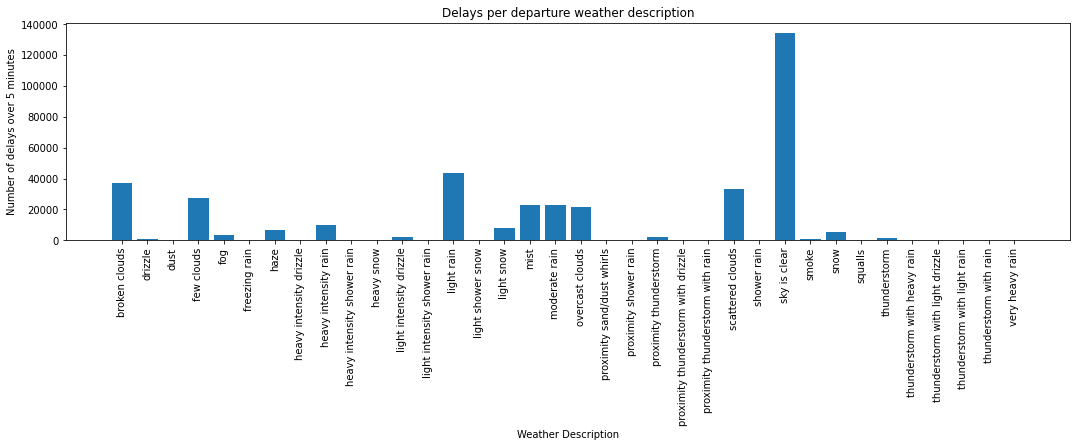

In [97]:
ylist = []

for airport in sorted(delay_count["ORIGIN_WEATHER"].unique()):
  ylist.append(delay_count[delay_count['ORIGIN_WEATHER'] == airport]["IS_DELAYED"].sum())

plt.figure(figsize = (18,4))

plt.bar(sorted(delay_count["ORIGIN_WEATHER"].unique()), ylist, bottom=0)
plt.title("Delays per departure weather description")
plt.xlabel("Weather Description")
plt.xticks(rotation = 90)
plt.ylabel("Number of delays over 5 minutes")
plt.show()

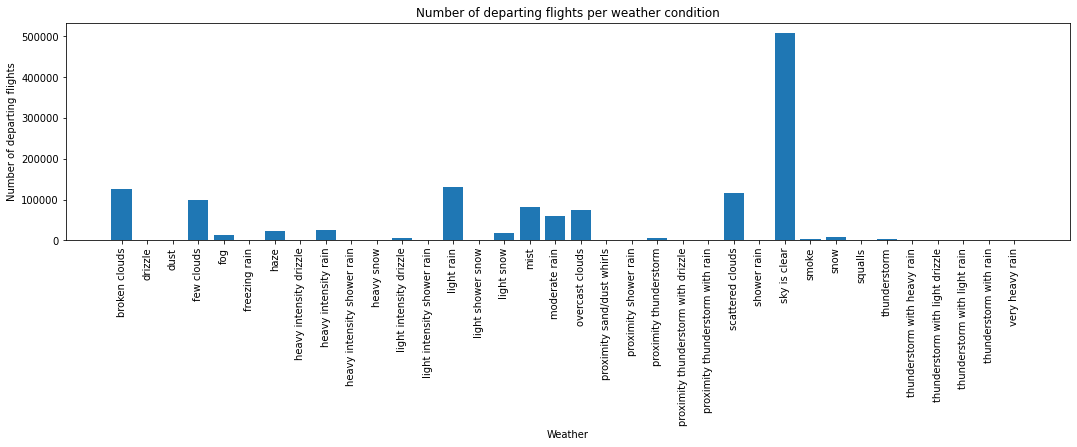

In [98]:
ylist2 = []

for airport in sorted(delay_count["ORIGIN_WEATHER"].unique()):
  ylist2.append(delay_count[delay_count['ORIGIN_WEATHER'] == airport]["IS_DELAYED"].count())


plt.figure(figsize=(18,4))
plt.bar(sorted(delay_count["ORIGIN_WEATHER"].unique()), ylist2, bottom=0)
plt.title("Number of departing flights per weather condition")
plt.xlabel("Weather")
plt.xticks(rotation = 90)
plt.ylabel("Number of departing flights")
plt.show()

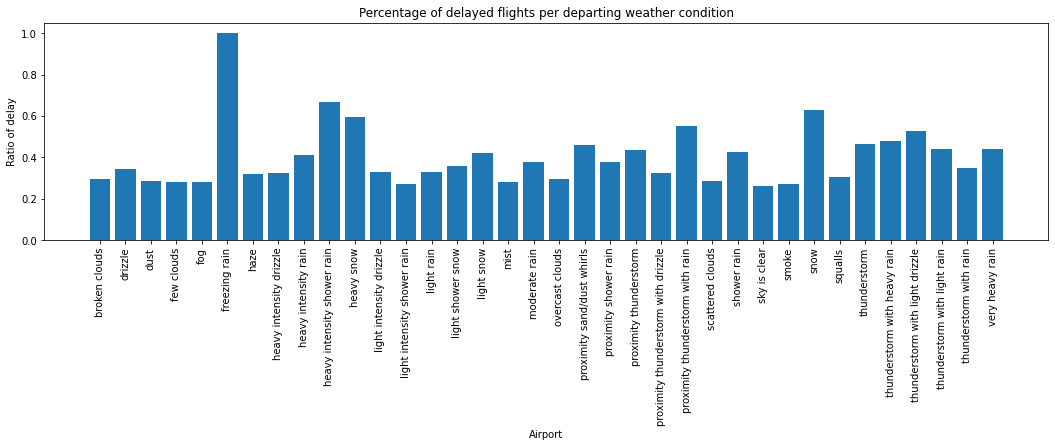

In [99]:
percent_delayed = [x/y for (x, y) in zip(ylist, ylist2)]

plt.figure(figsize=(18,4))
plt.bar(sorted(delay_count["ORIGIN_WEATHER"].unique()), percent_delayed, bottom=0)
plt.title("Percentage of delayed flights per departing weather condition")
plt.xlabel("Airport")
plt.xticks(rotation = 90)
plt.ylabel("Ratio of delay")
plt.show()

**Delays by destination weather**

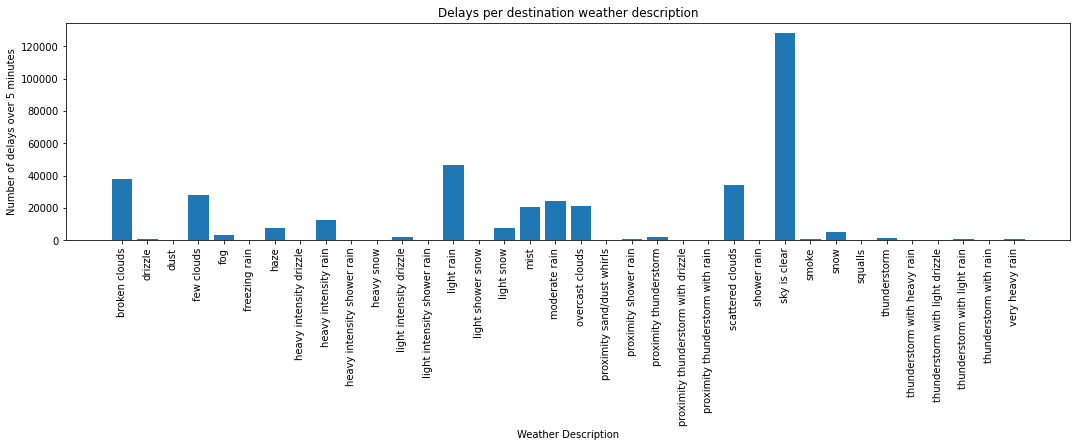

In [100]:
ylist = []

for airport in sorted(delay_count["DESTINATION_WEATHER"].unique()):
  ylist.append(delay_count[delay_count['DESTINATION_WEATHER'] == airport]["IS_DELAYED"].sum())

plt.figure(figsize = (18,4))

plt.bar(sorted(delay_count["DESTINATION_WEATHER"].unique()), ylist, bottom=0)
plt.title("Delays per destination weather description")
plt.xlabel("Weather Description")
plt.xticks(rotation = 90)
plt.ylabel("Number of delays over 5 minutes")
plt.show()

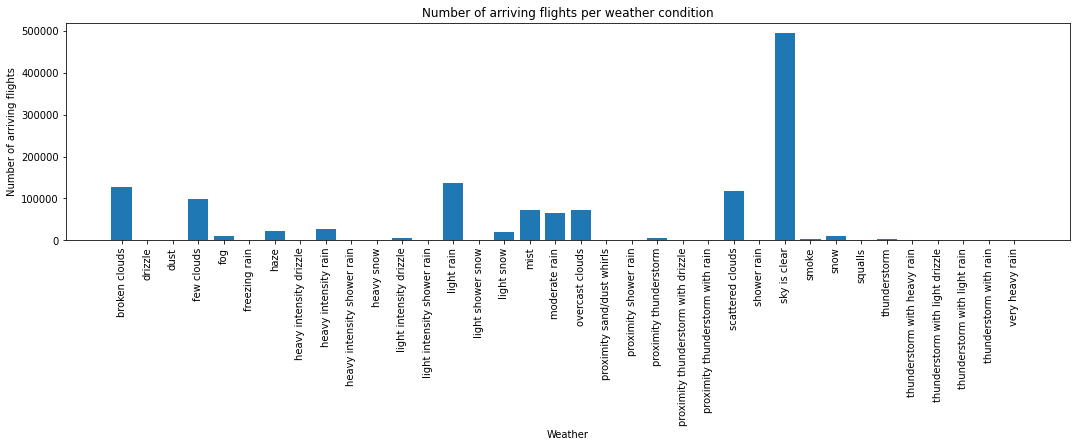

In [101]:
ylist2 = []

for airport in sorted(delay_count["DESTINATION_WEATHER"].unique()):
  ylist2.append(delay_count[delay_count['DESTINATION_WEATHER'] == airport]["IS_DELAYED"].count())


plt.figure(figsize=(18,4))
plt.bar(sorted(delay_count["DESTINATION_WEATHER"].unique()), ylist2, bottom=0)
plt.title("Number of arriving flights per weather condition")
plt.xlabel("Weather")
plt.xticks(rotation = 90)
plt.ylabel("Number of arriving flights")
plt.show()

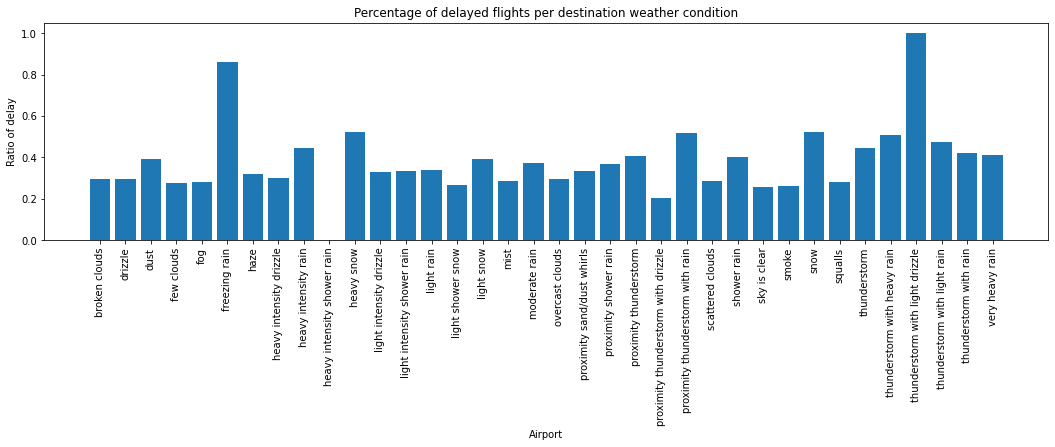

In [102]:
percent_delayed = [x/y for (x, y) in zip(ylist, ylist2)]

plt.figure(figsize=(18,4))
plt.bar(sorted(delay_count["DESTINATION_WEATHER"].unique()), percent_delayed, bottom=0)
plt.title("Percentage of delayed flights per destination weather condition")
plt.xlabel("Airport")
plt.xticks(rotation = 90)
plt.ylabel("Ratio of delay")
plt.show()

In [103]:
for column in wf_df.columns:
  if wf_df[column].dtype == "object":
    temp_df = pd.get_dummies(wf_df[column], prefix=column)
    wf_df = pd.concat([wf_df, temp_df], axis=1)
    wf_df = wf_df.drop(columns=[column])

wf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303781 entries, 0 to 1303780
Columns: 156 entries, MONTH to DESTINATION_WEATHER_very heavy rain
dtypes: float64(11), int64(10), uint8(135)
memory usage: 386.7 MB


In [104]:
wf_df.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,...,DESTINATION_WEATHER_sky is clear,DESTINATION_WEATHER_smoke,DESTINATION_WEATHER_snow,DESTINATION_WEATHER_squalls,DESTINATION_WEATHER_thunderstorm,DESTINATION_WEATHER_thunderstorm with heavy rain,DESTINATION_WEATHER_thunderstorm with light drizzle,DESTINATION_WEATHER_thunderstorm with light rain,DESTINATION_WEATHER_thunderstorm with rain,DESTINATION_WEATHER_very heavy rain
0,1,1,4,840,20,18.0,-2.0,16.0,34.0,286.0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,4,258,20,15.0,-5.0,15.0,30.0,285.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,806,25,20.0,-5.0,18.0,38.0,217.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,4,612,25,19.0,-6.0,11.0,30.0,181.0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,4,2013,30,44.0,14.0,13.0,57.0,273.0,...,1,0,0,0,0,0,0,0,0,0


Verifying that all columns containing object data types are removed

In [105]:
for column in wf_df.columns:
  if wf_df[column].dtype == "object":
    print(column)

There are too many columns for .corr to display all the information. I could not find the pandas setting for .corr print settings. All columns are printed with their correlation to Arrival delay in this loop.

In [106]:
for column in wf_df.columns:
  print("{} : {}".format(column, wf_df[column].corr(wf_df["ARRIVAL_DELAY"])))

MONTH : -0.021288643722592364
DAY : -0.0030027801743531604
DAY_OF_WEEK : -0.018311685596656222
FLIGHT_NUMBER : 0.016559939298738734
SCHEDULED_DEPARTURE : 0.10135473015987988
DEPARTURE_TIME : 0.14721895641968133
DEPARTURE_DELAY : 0.9386486405523962
TAXI_OUT : 0.23673601539548972
WHEELS_OFF : 0.14218637293141265
SCHEDULED_TIME : -0.04396698166386017
ELAPSED_TIME : 0.018745973599451588
AIR_TIME : -0.018479659591774333
DISTANCE : -0.03925290221783647
WHEELS_ON : 0.03358873285906363
TAXI_IN : 0.12392890429395133
SCHEDULED_ARRIVAL : 0.08552777482062171
ARRIVAL_TIME : 0.02328660049568326
ARRIVAL_DELAY : 1.0
DIVERTED : nan
CANCELLED : nan
IS_DELAYED : 0.6015454402560031
AIRLINE_AA : -0.017784803974724275
AIRLINE_AS : -0.02257699990660611
AIRLINE_B6 : 0.005947983768894185
AIRLINE_DL : -0.047342326770194405
AIRLINE_EV : 0.006253826762830138
AIRLINE_F9 : 0.03817979183188933
AIRLINE_MQ : 0.009407935747142783
AIRLINE_NK : 0.06120456091639818
AIRLINE_OO : 0.023128109648767433
AIRLINE_UA : 0.02058013

After cleaning, there are no remaining columns of cancelled or diverted flights. The columns are removed.

In [107]:
wf_df = wf_df.drop(columns=["CANCELLED", "DIVERTED"])

dropping IS_DELAYED to prevent influence on testing

In [108]:
wf_df = wf_df.drop(columns=["IS_DELAYED"])

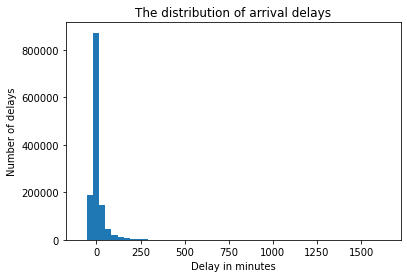

Mean: 4.928511766930182
Median: -5.0
Max: 1638.0
Min: -87.0


In [109]:
plt.hist(wf_df.ARRIVAL_DELAY, bins = 50)
plt.title("The distribution of arrival delays")
plt.xlabel("Delay in minutes")
plt.ylabel("Number of delays")
plt.show()

print("Mean: {}".format(wf_df.ARRIVAL_DELAY.mean()))
print("Median: {}".format(wf_df.ARRIVAL_DELAY.median()))
print("Max: {}".format(wf_df.ARRIVAL_DELAY.max()))
print("Min: {}".format(wf_df.ARRIVAL_DELAY.min()))

#Linear Regression Model

Using Linear regression to model arrival delays in minutes

**Linear Regression Model without arrival information**

Arrival information is removed as the delay can be interpretted from factors like arrival time, wheels on, or flight time.

In [110]:
#Defining Symmetric Mean Absolute Percentage Error as MAPE can not apply due to zeros in data

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [144]:
Y = wf_df["ARRIVAL_DELAY"]
X = wf_df.drop(columns=["ARRIVAL_DELAY", "ARRIVAL_TIME", "TAXI_IN", "WHEELS_ON", "AIR_TIME", "ELAPSED_TIME"])

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

print('\nIntercept: \n', lrm.intercept_)


Intercept: 
 5.961261694711652


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


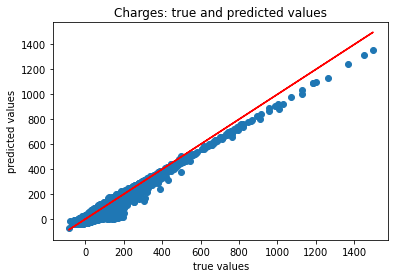

Mean absolute error of the prediction is: 7.191026921118458
Mean squared error of the prediction is: 97.67421264805724
Root mean squared error of the prediction is: 9.883026492328007
Mean absolute percentage error of the prediction is: inf
Symmetric Mean absolute percentage error of the prediction is: 69.99673234134727
Accuracy of the model determined by R2: 94.0


In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

lrm.fit(X_train, y_train)

X_train = sm.add_constant(X_train)

y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds, squared = False)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs(y_test - y_preds) / y_test) * 100))
print("Symmetric Mean absolute percentage error of the prediction is: {}".format(smape(y_test, y_preds)))
print("Accuracy of the model determined by R2: {}".format(round(r2_score(y_test, y_preds), 2) *100))

**Linear Regression Without Departure Delay**

Other departure features are kept as this is just a test of the influence that a departure delay would have on an arrival delay.

In [113]:
Y = wf_df["ARRIVAL_DELAY"]
X = wf_df.drop(columns=["ARRIVAL_DELAY", "ARRIVAL_TIME", "TAXI_IN", "WHEELS_ON", "AIR_TIME", "ELAPSED_TIME", "DEPARTURE_DELAY"])

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

print('\nIntercept: \n', lrm.intercept_)


Intercept: 
 15.044924047543132


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


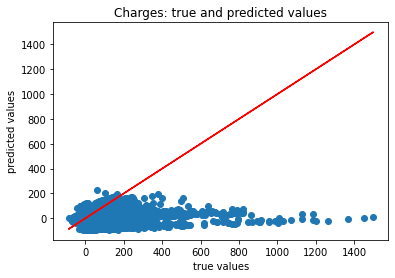

Mean absolute error of the prediction is: 19.70826939960598
Mean squared error of the prediction is: 1422.994307535129
Root mean squared error of the prediction is: 37.722596776138424
Mean absolute percentage error of the prediction is: inf
Symmetric Mean absolute percentage error of the prediction is: 134.03129964971637


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

lrm.fit(X_train, y_train)

X_train = sm.add_constant(X_train)

y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds, squared = False)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
print("Symmetric Mean absolute percentage error of the prediction is: {}".format(smape(y_test, y_preds)))
print("Accuracy of the model determined by R2: {}".format(round(r2_score(y_test, y_preds), 2) *100))

**Linear Regression With only Airport, Airline, Weather, Distance, and Scheduled arrival with Arrival delay as the target**

Checking the accuracy using only the weather based on each airline and airport. Scheduled arrival is kept to give some reference for the delay.

In [142]:
Y = wf_df["ARRIVAL_DELAY"]
X = wf_df.drop(columns=["MONTH", "DAY", "DAY_OF_WEEK", "FLIGHT_NUMBER", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", "ARRIVAL_TIME", "ELAPSED_TIME", "AIR_TIME", "WHEELS_ON", "ARRIVAL_DELAY", "TAXI_IN"])

lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

print('\nIntercept: \n', lrm.intercept_)


Intercept: 
 -1.0986941821415517


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


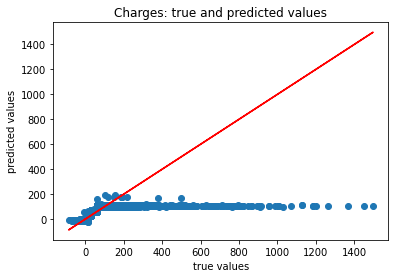

Mean absolute error of the prediction is: 12.19403608585442
Mean squared error of the prediction is: 593.0229245580417
Root mean squared error of the prediction is: 24.35206201860618
Mean absolute percentage error of the prediction is: inf
Symmetric Mean absolute percentage error of the prediction is: 84.50569660877285
Accuracy of the model determined by R2: 64.0


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

lrm.fit(X_train, y_train)

X_train = sm.add_constant(X_train)

y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(mean_squared_error(y_test, y_preds, squared = False)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
print("Symmetric Mean absolute percentage error of the prediction is: {}".format(smape(y_test, y_preds)))
print("Accuracy of the model determined by R2: {}".format(round(r2_score(y_test, y_preds), 2) *100))

# Decision Tree Classifier

Linear Regression struggled to find relationships between weather and the specific time of arrival delay as features dimminished. Turning the specific delay times into classifications based on their duration may prove to be more useful and easier to determine. 

In [117]:
delay =[]
for row in wf_df['ARRIVAL_DELAY']:
    if row > 60:
        delay.append(3)
    elif row > 30:
        delay.append(2)
    elif row > 15:
        delay.append(1)
    else:
        delay.append(0)  

wf_df["DELAY_CLASSIFIER"] = delay

In [118]:
wf_df.value_counts("DELAY_CLASSIFIER")

DELAY_CLASSIFIER
0    1053094
1      96027
3      77554
2      77106
dtype: int64

In [119]:
for column in wf_df.columns:
  print("{} : {}".format(column, wf_df[column].corr(wf_df["DELAY_CLASSIFIER"])))

MONTH : -0.022085243163543426
DAY : -0.005994539265841164
DAY_OF_WEEK : -0.0156447449721662
FLIGHT_NUMBER : 0.009568495341992297
SCHEDULED_DEPARTURE : 0.13290113723170507
DEPARTURE_TIME : 0.17672910962018623
DEPARTURE_DELAY : 0.7345647611407331
TAXI_OUT : 0.25683461014198944
WHEELS_OFF : 0.1738312758199585
SCHEDULED_TIME : -0.011355676271795498
ELAPSED_TIME : 0.04377525845085825
AIR_TIME : 0.005816518024576806
DISTANCE : -0.013665476979431096
WHEELS_ON : 0.057802151354672204
TAXI_IN : 0.11176946535390257
SCHEDULED_ARRIVAL : 0.10845258403568757
ARRIVAL_TIME : 0.04665458683623382
ARRIVAL_DELAY : 0.7939516075979648
AIRLINE_AA : -0.013577991870979165
AIRLINE_AS : -0.030864523457424534
AIRLINE_B6 : 0.01858827518210568
AIRLINE_DL : -0.05598299987302427
AIRLINE_EV : 0.0028271381448699
AIRLINE_F9 : 0.033727802904142824
AIRLINE_MQ : 0.015446611461425406
AIRLINE_NK : 0.06928694309039846
AIRLINE_OO : 0.017364321700046596
AIRLINE_UA : 0.028012094810550114
AIRLINE_US : -0.012403688476766742
AIRLINE

**Without Arrival information**

In [120]:
Y = wf_df["DELAY_CLASSIFIER"]
X = wf_df.drop(columns=["ARRIVAL_DELAY", "ARRIVAL_TIME", "TAXI_IN", "WHEELS_ON", "AIR_TIME", "ELAPSED_TIME"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 50)

In [121]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [122]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 1.0


**Without Departure Delay**

In [123]:
Y = wf_df["DELAY_CLASSIFIER"]
X = wf_df.drop(columns=["ARRIVAL_DELAY", "ARRIVAL_TIME", "TAXI_IN", "WHEELS_ON", "AIR_TIME", "ELAPSED_TIME", "DEPARTURE_DELAY", "DELAY_CLASSIFIER"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 50)

In [124]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [125]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.7879206310649921


**Only using airports, airlines, and weather**

In [126]:
Y = wf_df["DELAY_CLASSIFIER"]
X = wf_df.drop(columns=["MONTH", "DAY", "DAY_OF_WEEK", "FLIGHT_NUMBER", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", "ARRIVAL_TIME", "ELAPSED_TIME", "AIR_TIME", "WHEELS_ON", "ARRIVAL_DELAY", "TAXI_IN", "DELAY_CLASSIFIER"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 50)

In [127]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [128]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.5384292068033517


# Random forest classifier with adjustments

To try to find the relationship between weather and delays. I'll focus on only modeling airports, airlines, and weather conditions.

**Only using airports, airlines, and weather with adjusted depth**

In [129]:
Y = wf_df["DELAY_CLASSIFIER"]
X = wf_df.drop(columns=["MONTH", "DAY", "DAY_OF_WEEK", "FLIGHT_NUMBER", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_TIME", "ARRIVAL_TIME", "ELAPSED_TIME", "AIR_TIME", "WHEELS_ON", "ARRIVAL_DELAY", "TAXI_IN", "DELAY_CLASSIFIER"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 50)

max depth of 10

In [130]:
clf = DecisionTreeClassifier(max_depth = 10)
clf = clf.fit(X_train, y_train)

In [131]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.633037942995538


max depth of 15

In [132]:
clf = DecisionTreeClassifier(max_depth = 15)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6359931223522288


max depth of 20

In [133]:
clf = DecisionTreeClassifier(max_depth = 20)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6179683750182252


**minimum split adjustment**

minimum sample split set to 5

In [134]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 5)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6366827308878035


minimum sample split set to 10

In [135]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 10)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6379328415457061


minimum sample split set to 20

In [136]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 20)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6397562531588097


minimum sample split set to 30

In [137]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 30)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6409731811252817


minimum sample split set to 50

In [138]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 50)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6419808621580356


minimum sample split set to 100

In [139]:
clf = DecisionTreeClassifier(max_depth = 15, min_samples_split = 100)
clf = clf.fit(X_train, y_train)

pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print("Accuracy of the Decision Tree: {}".format(auc_score))

Accuracy of the Decision Tree: 0.6430742111707608


# Conclusion

Linear Regression can be very accurate for determining arrival delays when only arrival information is removed. Removing more features greatly reduces the accuracy of the model. The model remained accurate for 64% of the predictions when looking at only airports, airlines, and weather.

Splitting the delays into 4 categories based on 15 minute intervals provides more accurate modeling of the delays that can be tested with a decision tree classifier. The decision tree had an accuracy of 53% using only the weather, airports, and airline of the flights. By adjusting the maximum depth to 15 and the minimum sample split to 100%, the accuracy of the decision tree is improved to 64% making it the best model for the problem. Having the delays broken into classifications would likely prove to be more useful than looking for specific times. Determining if there will be a delay at all is useful and trying to find the specific time of the delay would likely require information about the flight conditions between airports which the dataset does not provide. 